# BUG IT WAS USING ONLY CHARS - WORKS KIND OF BUT ALL WORDS INFO WAS LOST

# BUG IT WAS USING ONLY CHARS - WORKS KIND OF BUT ALL WORDS INFO WAS LOST

# BUG IT WAS USING ONLY CHARS - WORKS KIND OF BUT ALL WORDS INFO WAS LOST

# BUG IT WAS USING ONLY CHARS - WORKS KIND OF BUT ALL WORDS INFO WAS LOST

In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'category_8_fixes'

In [4]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [24]:
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
sample_data = all_data[all_data['class'] != 'MANUAL']
del(all_data)

In [25]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['ELECTRONIC', 'LETTERS', 'NOT_CHANGED', 'NUMBERS', 'PLAIN', 'VERBATIM']
6


### Utils stuff

In [26]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


In [27]:
common_words, common_words_index = load_common_words_10k()
len(common_words)
common_words[0:10]

8192

['<EOS>', '<SOS>', '<UNK>', '<0000>', '<SAMPLE>', '.', ',', 'the', '"', 'of']

### More balanced sample

In [29]:
balanced_data_classes_select = list(sample_data.groupby('class'))

balanced_data_accessed_counter = 0 
balanced_data_randomize_freq = False
balanced_data_length = 0

def balanced_data_randomize_org(max_len=20000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter, balanced_data_randomize_freq
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data_length = len(balanced_data)
    balanced_data_randomize_freq = balanced_data_length * 0.2
    balanced_data_accessed_counter = 0
balanced_data_randomize = balanced_data_randomize_org

def balanced_data_sample_row():
    global balanced_data_accessed_counter
    global balanced_data_last_sample
    balanced_data_accessed_counter += 1
    if balanced_data_randomize_freq and balanced_data_accessed_counter > balanced_data_randomize_freq:
        balanced_data_randomize()
    balanced_data_last_sample = balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    return balanced_data_last_sample
    
balanced_data_randomize()

In [30]:
balanced_data.groupby("class")["class"].count()

class
ELECTRONIC      4964
LETTERS        20000
NOT_CHANGED    20000
NUMBERS        20000
PLAIN          20000
VERBATIM       11741
Name: class, dtype: int64

### Samples

In [94]:
def get_random_sample():
    sample_row = balanced_data_sample_row()   
    return sample_row['before'], sample_row['after'], sample_row['class'], sample_row['sentence']

def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    print(s_class, ':', s_bef, '->', s_aft)
    print(s_sentence)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
    words_t = words_to_tensor(list(s_sentence), common_words_index)
    print(words_t.size())
    #return words_t[0]
    print([common_words[w[0]] for w in words_t[0].topk(1)[1]])
    
tmp = tmp()

NOT_CHANGED : was -> was
in august 2014 , it <SAMPLE> announced that moore would be joining the cast of hollyoaks as porsche mcqueen .
torch.Size([1, 4, 104])
torch.Size([1, 110, 8192])
['i', 'n', '<UNK>', 'a', 'u', 'g', 'u', 's', 't', '<UNK>', '2', '0', '1', '4', '<UNK>', ',', '<UNK>', 'i', 't', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', 'a', 'n', 'n', 'o', 'u', 'n', 'c', 'e', 'd', '<UNK>', 't', 'h', 'a', 't', '<UNK>', 'm', 'o', 'o', 'r', 'e', '<UNK>', 'w', 'o', 'u', 'l', 'd', '<UNK>', 'b', 'e', '<UNK>', 'j', 'o', 'i', 'n', 'i', 'n', 'g', '<UNK>', 't', 'h', 'e', '<UNK>', 'c', 'a', 's', 't', '<UNK>', 'o', 'f', '<UNK>', 'h', 'o', 'l', 'l', 'y', 'o', 'a', 'k', 's', '<UNK>', 'a', 's', '<UNK>', 'p', 'o', 'r', 's', 'c', 'h', 'e', '<UNK>', 'm', 'c', 'q', 'u', 'e', 'e', 'n', '<UNK>', '.', '<EOS>']


# BUG IT WAS USING ONLY CHARS - WORKS KIND OF BUT ALL WORDS INFO WAS LOST

# Model

In [34]:
class CategorizeRNN(nn.Module):
    def __init__(self, output_size, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_dropout=0, chars_dropout=0, words_layers=1, chars_layers=1):
        super(CategorizeRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size

        self.rnn_words = nn.LSTM(words_input_size, words_hidden_size // 2, words_layers,
                                 dropout=words_dropout, batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size // 2, chars_layers,
                                 dropout=chars_dropout, batch_first=True, bidirectional=True)
        
        self.lin_output = nn.Linear(words_hidden_size+chars_hidden_size, output_size)
        
    def forward(self, words_tensor, string_tensor, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(words_tensor, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        output = torch.cat((output_words, output_chars), 1)
        
        output = self.lin_output(output)
        output = F.log_softmax(output)
        
        return output

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))

In [41]:
model = CategorizeRNN(len(categories_all), 
                      words_input_size=len(common_words), chars_input_size=len(chars_normal),
                      words_hidden_size=256, chars_hidden_size=384,
                      words_layers=2, chars_layers=2,
                      words_dropout=0.2, chars_dropout=0.2)
model = model.cuda()

model_training = ModelTraining(MODEL_SAVE_PATH, [model])

model

Save path: data/models/category_8_fixes


CategorizeRNN (
  (rnn_words): LSTM(8192, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (rnn_chars): LSTM(104, 192, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (lin_output): Linear (640 -> 6)
)

### Accuracy

In [95]:
def test_model_single_sample(model):
    s_bef, s_aft, s_class, s_sentence = sample = get_random_sample()
    
    words_t = words_to_tensor(list(s_sentence), common_words_index)
    words_t = Variable(words_t).cuda()
    
    print(words_t.size()) # THIS IS TOTALLY WRONG, NOT USiNG WORDS BUT CHARS
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    output = model(words_t, string_t)
    guess = category_from_output(output, categories_all)

    return output, guess, (s_class, categories_index[s_class]), sample
    
tmp = test_model_single_sample(model)
tmp

torch.Size([1, 94, 8192])


(Variable containing:
 -2.5207e+01 -9.6992e+00 -1.3651e+01 -2.0422e+01 -6.2466e-05 -2.2194e+01
 [torch.cuda.FloatTensor of size 1x6 (GPU 0)],
 ('PLAIN', 4),
 ('PLAIN', 4),
 ('vs',
  'versus',
  'PLAIN',
  '27 , 2003 single game yards passing : 586 ( rank 23rd ) ( <SAMPLE> north carolina st ) sept .'))

In [43]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(model, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        m = torch.nn.functional.softmax(output).max().data[0]
        print("{:>11} -> {:>11} ({:0.3}) || {:>8} -> {} == {}".format(s_class, predict[0], m, s_bef, s_aft, ' '.join(s_sentence), ))

In [44]:
print_local_wrong_predictions(max_results=1)

    NUMBERS ->       PLAIN (0.17) || 9780966204292 -> nine trillion seven hundred eighty billion nine hundred sixty six million two hundred four thousand two hundred ninety two == p o e m s   :   b e a u   s i a   :   < S A M P L E >   :   a m a z o n   .   c o m   :   b o o k s   "   .


### Training

In [45]:
def train(model, s_category, s_sentence, s_bef, loss_function, optimizer):
    
    category_tensor = Variable(torch.LongTensor([categories_index[s_category]])).cuda()
    
    words_t = words_to_tensor(list(s_sentence), common_words_index)
    words_t = Variable(words_t).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    output = model(words_t, string_t)
    loss = loss_function(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.data[0]

In [46]:
def train_iterations(n_iters=100000, lr=0.001, print_every=10000, plot_every=1000):

    start = time.time()
    model.train()

    current_loss = 0
    current_loss_iter = 0

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(model=model, s_category=s_class, s_sentence=s_sentence,
                             s_bef=s_bef, optimizer=optimizer, loss_function=loss_function)

        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            guess, guess_i = category_from_output(result, categories_all)
            correct = '✓' if guess == s_class else "✗ {}".format(s_class)
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({})".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, guess, correct))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(model, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [47]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   1.791   |   1.77: June 2011 -> LETTERS (✗ NUMBERS)
Saved model to data/models/category_8_fixes/10_(CategorizeRNN)
Accuracy: 27.49% (    2749/   10000)
    18  36% (   1m 5s)   1.788   |   1.75: 5 February 1967 -> NUMBERS (✓)
    27  54% (   1m 6s)   1.785   |   1.76: - -> PLAIN (✓)
    36  72% (   1m 6s)   1.791   |   1.75: 1919 -> LETTERS (✗ NUMBERS)
    45  90% (   1m 6s)   1.789   |   1.77: the -> LETTERS (✗ NOT_CHANGED)


In [48]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (   0m 8s)   1.687   |   1.68: UCLA -> NUMBERS (✗ LETTERS)


In [49]:
train_iterations(n_iters=10000, lr=0.0001, print_every=1000)

  2000  10% (  0m 16s)   0.967   |   1.66: . -> VERBATIM (✗ NOT_CHANGED)
  3000  20% (  0m 33s)   0.691   |   0.25: Deadline.comViagas -> ELECTRONIC (✓)
  4000  30% (  0m 50s)   0.623   |   0.20: MA -> LETTERS (✓)
  5000  40% (   1m 7s)   0.516   |   0.00: 242.0 -> NUMBERS (✓)
  6000  50% (  1m 24s)   0.438   |   0.54: theatre -> PLAIN (✓)
  7000  60% (  1m 42s)   0.450   |   0.02: 07 -> NUMBERS (✓)
  8000  70% (  1m 59s)   0.447   |   0.01: API -> LETTERS (✓)
  9000  80% (  2m 16s)   0.409   |   0.19: - -> PLAIN (✓)
 10000  90% (  2m 34s)   0.401   |   0.07: S. -> LETTERS (✓)
 11000 100% (  2m 51s)   0.370   |   0.00: & -> VERBATIM (✓)


In [50]:
train_iterations(n_iters=89000, print_every=10000)

 21000  11% (  2m 46s)   0.167   |   0.00: # -> VERBATIM (✓)
 31000  22% (  5m 27s)   0.220   |   0.42: collections -> NOT_CHANGED (✓)
 41000  34% (   8m 8s)   0.120   |   0.00: Britannica.com -> ELECTRONIC (✓)
Saved model to data/models/category_8_fixes/50000_(CategorizeRNN)
Accuracy: 96.67% (    9667/   10000)
 51000  45% (  12m 1s)   0.100   |   0.00: S. -> LETTERS (✓)
 61000  56% (  15m 3s)   0.061   |   0.00: S. -> LETTERS (✓)
 71000  67% (  18m 9s)   0.081   |   0.00: mr -> PLAIN (✓)
 81000  79% ( 20m 59s)   0.123   |   0.17: ff -> LETTERS (✓)
 91000  90% ( 23m 43s)   0.071   |   0.02: IJN -> LETTERS (✓)
Saved model to data/models/category_8_fixes/100000_(CategorizeRNN)
Accuracy: 97.89% (    9789/   10000)


In [51]:
print_local_wrong_predictions()

NOT_CHANGED ->       PLAIN (0.97) ||        : -> : == n e w   y o r k   < S A M P L E >   r o u t l e d g e   ,   2 0 1 0   .
    LETTERS -> NOT_CHANGED (0.888) ||   Ciprés -> c i p r e acute s == t h e y   t r a v e l e d   t o   e l   < S A M P L E >   ,   l o c a t e d   i n   s i e r r a   d e   l a s   m i n a s   ,   m i l e s   n o r t h   o f   t h e   m o t a g u a   r i v e r   v a l l e y   .
      PLAIN ->    VERBATIM (0.93) ||        ~ -> to == "   p c   n e w s   t o p   5 0   s a l e s   r a n k i n g   f o r   b i s h o j o   g a m e s   s o l d   i n   j a p a n   n o   1 0 0   (   5   /   1 6   < S A M P L E >   5   /   3 1   )   "   (   i n   j a p a n e s e   )   .
      PLAIN -> NOT_CHANGED (0.899) ||   yahoo! -> yahoo == o n   s e p t e m b e r   9   ,   < S A M P L E >
      PLAIN -> NOT_CHANGED (0.979) || Muhlenweg -> muhlen weg == g o t t a r d i   ,   e   ;   k r a w c z y k   ,   j   .   ;   v o n   s u c h o d o l e t z   ,   h   .   ;   s c h a d t   ,   s 

In [55]:
train_iterations(n_iters=100000, lr=0.0005, print_every=10000)

110000  10% (  2m 40s)   0.044   |   0.00: neighbouring -> PLAIN (✓)
120000  20% (  5m 22s)   0.070   |   0.00: H. -> LETTERS (✓)
130000  30% (   8m 3s)   0.050   |   0.00: . -> NOT_CHANGED (✓)
140000  40% ( 10m 44s)   0.066   |   0.00: & -> VERBATIM (✓)
150000  50% ( 13m 27s)   0.067   |   0.00: 146 -> NUMBERS (✓)
Saved model to data/models/category_8_fixes/150000_(CategorizeRNN)
Accuracy: 98.42% (    9842/   10000)
160000  60% ( 17m 13s)   0.053   |   0.00: $3 -> NUMBERS (✓)
170000  70% ( 19m 54s)   0.044   |   0.00: & -> VERBATIM (✓)
180000  80% ( 22m 35s)   0.038   |   0.01: local -> NOT_CHANGED (✓)
190000  90% ( 25m 15s)   0.052   |   0.00: http://www.arrahman.com -> ELECTRONIC (✓)
200000 100% ( 27m 56s)   0.056   |   0.00: NBC -> LETTERS (✓)
Saved model to data/models/category_8_fixes/200000_(CategorizeRNN)
Accuracy: 98.72% (    9872/   10000)


In [56]:
print_local_wrong_predictions()

      PLAIN -> NOT_CHANGED (0.959) ||   meagre -> meager == h i s   f i r s t   e a r n i n g s   w e r e   < S A M P L E >   ,   a b o u t   f i v e   s h i l l i n g s   p e r   w e e k   i n   w h i t s t a b l e   ,   a n d   h e   f a c e d   f r e q u e n t   p r i v a t i o n   .
      PLAIN ->     LETTERS (0.99) ||      CLL -> calle == "   t h e   c u t   o f f   l e v e l s   o f   c d   2 3   e x p r e s s i o n   i n   t h e   d i f f e r e n t i a l   d i a g n o s i s   o f   m c l   a n d   < S A M P L E >   "   .
NOT_CHANGED ->       PLAIN (0.726) ||        : -> : == o c t o b e r   < S A M P L E >   k i s h i w a d a   d a n j i r i   m a t s u r i   ,   m o u n t a i n   d i s t r i c t s   .
      PLAIN ->     LETTERS (0.999) ||      CPL -> corporal == i n   c o m p u t i n g   ,   t h e   c o m m o n   p u b l i c   l i c e n s e   (   < S A M P L E >   )   i s   a   f r e e   s o f t w a r e   /   o p e n   s o u r c e   s o f t w a r e   l i c e n s e   p u b l i s

In [57]:
train_iterations(n_iters=100000, lr=0.001, print_every=10000)

210000  10% (  2m 42s)   0.068   |   0.00: # -> VERBATIM (✓)
220000  20% (  5m 25s)   0.058   |   0.00: 169 -> NUMBERS (✓)
230000  30% (   8m 8s)   0.088   |   0.00: to -> NOT_CHANGED (✓)
240000  40% ( 10m 50s)   0.074   |   0.00: A.J. -> LETTERS (✓)
250000  50% ( 13m 31s)   0.054   |   0.00: - -> PLAIN (✓)
Saved model to data/models/category_8_fixes/250000_(CategorizeRNN)
Accuracy: 97.75% (    9775/   10000)
260000  60% ( 17m 15s)   0.045   |   0.01: no -> PLAIN (✓)
270000  70% ( 19m 55s)   0.041   |   0.00: with -> NOT_CHANGED (✓)
280000  80% ( 22m 38s)   0.093   |   0.00: Theatre -> PLAIN (✓)
290000  90% ( 25m 18s)   0.092   |   0.01: utilised -> PLAIN (✓)
300000 100% (  28m 1s)   0.049   |   0.00: 10 -> NUMBERS (✓)
Saved model to data/models/category_8_fixes/300000_(CategorizeRNN)
Accuracy: 98.64% (    9864/   10000)


In [58]:
print_local_wrong_predictions()

NOT_CHANGED ->     LETTERS (0.992) ||     UEFA -> UEFA == w i t h   m e n d o z a   a s   p r e s i d e n t   t h e   c l u b   w o n   6   s p a n i s h   l i g a s   ,   2   s p a n i s h   c u p s   ,   1   < S A M P L E >   c u p   a n d   3   s u p e r   c u p s   .
    LETTERS ->       PLAIN (0.915) ||      qtd -> q t d == i f   t h e r e   i s   a   r e s u r g e n c e   i n   p u b l i c   s e r v i c e   b r o a d c a s t i n g   ,   h o p e f u l l y   i t   w i l l   b e   u n i v e r s a l   "   (   < S A M P L E >   .
    LETTERS ->       PLAIN (1.0) ||      std -> s t d == 5 t h   -   7 t h   s t d   p i c n i c   a n d   8 t h   -   9 t h   < S A M P L E >   p i c n i c   a r e   t a k e n   o n   s e p a r a t e   d a y s   b y   m o r n i n g   a n d   a f t e r n o o n   s h i f t   t e a c h e r s   r e s p e c t i v e l y   .
NOT_CHANGED ->       PLAIN (0.603) || television -> television == s h e   i n s t e a d   f o c u s e d   o n   < S A M P L E >   .
    LETTER

In [59]:
train_iterations(n_iters=200000, lr=0.0005, print_every=10000)

310000   5% (  2m 42s)   0.065   |   0.00: 23 January 2013 -> NUMBERS (✓)
320000  10% (  5m 24s)   0.034   |   0.00: vs -> PLAIN (✓)
330000  15% (   8m 5s)   0.039   |   0.00: KGP- -> LETTERS (✓)
340000  20% ( 10m 47s)   0.065   |   0.00: B. -> LETTERS (✓)
350000  25% ( 13m 29s)   0.034   |   0.00: 1890s -> NUMBERS (✓)
Saved model to data/models/category_8_fixes/350000_(CategorizeRNN)
Accuracy: 99.00% (    9900/   10000)
360000  30% ( 17m 13s)   0.036   |   0.00: vs -> PLAIN (✓)
370000  35% ( 19m 54s)   0.017   |   0.00: vol -> PLAIN (✓)
380000  40% ( 22m 34s)   0.035   |   0.00: & -> VERBATIM (✓)
390000  45% ( 25m 17s)   0.040   |   0.00: dr -> PLAIN (✓)
400000  50% ( 27m 58s)   0.052   |   0.00: June 1887 -> NUMBERS (✓)
Saved model to data/models/category_8_fixes/400000_(CategorizeRNN)
Accuracy: 98.80% (    9880/   10000)
410000  55% ( 31m 43s)   0.028   |   0.00: 1.21 million -> NUMBERS (✓)
420000  60% ( 34m 24s)   0.044   |   0.00: gives -> NOT_CHANGED (✓)
430000  65% (  37m 4s)   

In [60]:
print_local_wrong_predictions()

NOT_CHANGED ->     NUMBERS (0.974) ||        I -> I == t h i s   p o s i t i o n   w a s   u n t e n a b l e   f o r   t h e   c h u r c h   o f   c o n s t a n t i n o p l e   a n d   p a t r i a r c h   p a c h o m i u s   < S A M P L E >   o f   c o n s t a n t i n o p l e   i n v i t e d   a r s e n i u s   t o   a b d i c a t e   .
NOT_CHANGED ->       PLAIN (0.819) ||        : -> : == t o r o n t o   < S A M P L E >   u n i v e r s i t y   o f   t o r o n t o   p r e s s   ,   p p   .
NOT_CHANGED ->       PLAIN (0.672) ||     TOUR -> TOUR == "   a l a n i s   m o r i s s e t t e   a n d   b a r e n a k e d   l a d i e s   t o   c o   -   h e a d l i n e   t h e   '   a u   n a t u r a l e   '   s u m m e r   < S A M P L E >   "   (   p r e s s   r e l e a s e   )   .
NOT_CHANGED ->       PLAIN (0.822) ||        : -> : == t e h r a n   < S A M P L E >   e n t e s h a r a t   s h a f i '   i   ,   1 9 9 9   ,   p p   .
NOT_CHANGED ->     LETTERS (0.793) ||     Saar -> Saar == a l e

In [61]:
train_iterations(n_iters=200000, lr=0.0001, print_every=25000)

525000  12% (  6m 40s)   0.050   |   0.00: . -> NOT_CHANGED (✓)
550000  25% ( 13m 21s)   0.038   |   0.00: FC -> LETTERS (✓)
Saved model to data/models/category_8_fixes/550000_(CategorizeRNN)
Accuracy: 99.14% (    9914/   10000)
575000  38% (  21m 7s)   0.017   |   0.00: Elisabeth -> PLAIN (✓)
600000  50% ( 27m 51s)   0.039   |   0.00: vol -> PLAIN (✓)
Saved model to data/models/category_8_fixes/600000_(CategorizeRNN)
Accuracy: 99.15% (    9915/   10000)
625000  62% ( 35m 38s)   0.040   |   0.00: Derek -> NOT_CHANGED (✓)
650000  75% ( 42m 23s)   0.033   |   0.00: & -> VERBATIM (✓)
Saved model to data/models/category_8_fixes/650000_(CategorizeRNN)
Accuracy: 99.09% (    9909/   10000)
675000  88% ( 50m 12s)   0.016   |   0.00: of -> NOT_CHANGED (✓)
700000 100% ( 58m 40s)   0.023   |   0.00: to -> NOT_CHANGED (✓)
Saved model to data/models/category_8_fixes/700000_(CategorizeRNN)
Accuracy: 99.24% (    9924/   10000)


In [62]:
print_local_wrong_predictions()

NOT_CHANGED ->       PLAIN (0.996) ||        - -> - == l i l l i e   b e l l e   j o h n s o n   (   n o r m a   d o n a l d s o n   )   < S A M P L E >   w a l t e r   ' s   w i f e   .
    LETTERS -> NOT_CHANGED (0.625) ||     Aart -> a a r t == h e n d r i k s   ,   < S A M P L E >   (   n o v   2 0 0 7   )   .
    LETTERS -> NOT_CHANGED (0.701) ||    lviii -> l v i i i == 7 2   c a s s i u s   d i o   ,   < S A M P L E >   .
NOT_CHANGED ->     LETTERS (0.747) ||     Cosa -> Cosa == r u g g i e r o   w a s   a n   o l d   s c h o o l   < S A M P L E >   n o s t r a   m o b s t e r   w h o   k n e w   h o w   m a f i a   p o l i t i c s   w o r k e d   .
    LETTERS -> NOT_CHANGED (0.654) ||     Peao -> p e a o == i t s   m a i n   e v e n t   i s   t h e   r o d e o   -   < S A M P L E >   d e   r o d e i o   d e   i c é m   .
    LETTERS ->     NUMBERS (1.0) ||       II -> i i == c z t s   i s   a   i   2   -   < S A M P L E >   -   i v   -   v i   4   q u a t e r n a r y   c o m p

In [ ]:
time.sleep(40*60*60)

In [ ]:
train_iterations(n_iters=300000, lr=0.0001, print_every=10000)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=300000, lr=0.00005, print_every=10000)

In [ ]:
print_local_wrong_predictions()

# Results

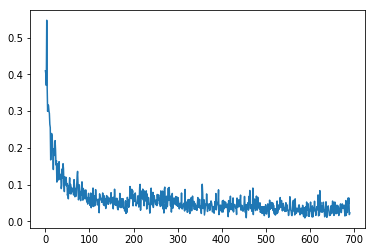

In [69]:
plt.figure()
plt.plot(model_training.losses[7:])

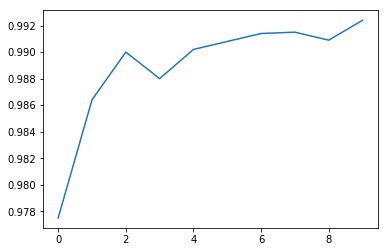

In [66]:
plt.figure()
plt.plot(model_training.accuracy[5:])

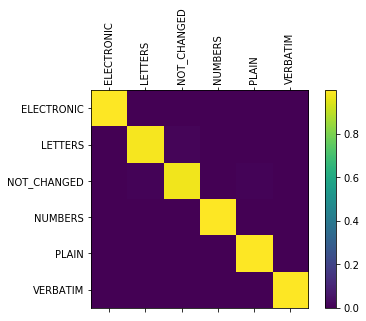

Accuracy: 99.19% (   49595/   50000)
CPU times: user 29min 26s, sys: 27.1 s, total: 29min 53s
Wall time: 8min 29s


In [70]:
%%time
plot_category_confusion_matrix(model, categories_all, test_model_single_sample, n_confusion=50000)

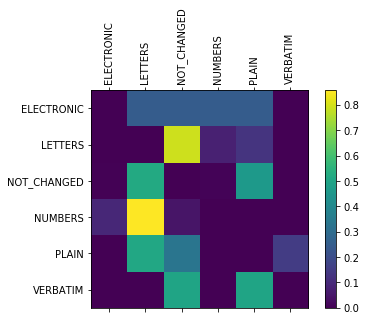

Accuracy: 99.09% (   49547/   50000)
CPU times: user 30min 19s, sys: 27.6 s, total: 30min 46s
Wall time: 7min 47s


In [71]:
%%time
plot_category_confusion_matrix(model, categories_all, test_model_single_sample,
                               n_confusion=50000, remove_diagonal=True)